In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

from xgboost import XGBClassifier


2025-08-31 08:15:01.865994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756628102.088335      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756628102.153869      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = "/kaggle/input/coffee-bean-tanvir/train"
test_dir  = "/kaggle/input/coffee-bean-tanvir/test"

# Training Data Generator (with validation split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(128,128), batch_size=32,
    class_mode='categorical', shuffle=True, subset='training'
)

# Validation generator
val_gen = train_datagen.flow_from_directory(
    train_dir, target_size=(128,128), batch_size=32,
    class_mode='categorical', shuffle=False, subset='validation'
)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=(128,128), batch_size=32,
    class_mode='categorical', shuffle=False
)

print("Train classes mapping:", train_gen.class_indices)
print("Validation classes mapping:", val_gen.class_indices)
print("Test classes mapping:", test_gen.class_indices)


Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Train classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Validation classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
Test classes mapping: {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}


In [4]:
def self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128):
    h, w, c = x.shape[1], x.shape[2], x.shape[3]
    reshaped = layers.Reshape((-1, c))(x)

    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(reshaped, reshaped)
    attn_output = layers.Add()([reshaped, attn_output])
    attn_output = layers.LayerNormalization()(attn_output)

    ffn = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn = layers.Dense(c)(ffn)
    ffn_output = layers.Add()([attn_output, ffn])
    ffn_output = layers.LayerNormalization()(ffn_output)

    return layers.Reshape((h, w, c))(ffn_output)


In [5]:
def build_sa_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=128)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = self_attention_block(x, num_heads=4, key_dim=32, ff_dim=256)

    gap = layers.GlobalAveragePooling2D()(x)

    dense = layers.Dense(256, activation='relu')(gap)
    dense = layers.Dropout(0.5)(dense)
    outputs = layers.Dense(num_classes, activation='softmax')(dense)

    return models.Model(inputs, outputs)


In [6]:
num_classes = train_gen.num_classes
sa_model = build_sa_cnn(input_shape=(128,128,3), num_classes=num_classes)

sa_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = sa_model.fit(
    train_gen, validation_data=val_gen, epochs=20, verbose=1
)


I0000 00:00:1756628116.018406      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756628127.356514     117 service.cc:148] XLA service 0x7aedbc04e9f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756628127.357684     117 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756628128.383419     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/30 ━━━━━━━━━━━━━━━━━━━━ 7:57 16s/step - accuracy: 0.2188 - loss: 1.6335

I0000 00:00:1756628134.578482     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 507ms/step - accuracy: 0.2440 - loss: 1.6213 - val_accuracy: 0.2500 - val_loss: 1.4412
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - accuracy: 0.3030 - loss: 1.3740 - val_accuracy: 0.6417 - val_loss: 0.9845
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 267ms/step - accuracy: 0.5736 - loss: 0.8681 - val_accuracy: 0.5833 - val_loss: 0.7960
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.6514 - loss: 0.7337 - val_accuracy: 0.6292 - val_loss: 0.8196
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.7362 - loss: 0.5688 - val_accuracy: 0.6542 - val_loss: 0.8056
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.7134 - loss: 0.6859 - val_accuracy: 0.9000 - val_loss: 0.3248
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.9163 - loss: 0.2774 - val_accuracy: 0.9000 - val_loss: 0.2544
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.9270 - loss: 0.2270 - val_accuracy: 0.9208 - val

In [7]:
# Take output before Dense head (GAP layer)
feature_extractor = models.Model(
    inputs=sa_model.input,
    outputs=sa_model.layers[-4].output
)

def extract_features(model, generator):
    features, labels = [], []
    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        feat = model.predict(x_batch, verbose=0)
        features.append(feat)
        labels.append(np.argmax(y_batch, axis=1))
    return np.vstack(features), np.hstack(labels)

X_train, y_train = extract_features(feature_extractor, train_gen)
X_val, y_val     = extract_features(feature_extractor, val_gen)
X_test, y_test   = extract_features(feature_extractor, test_gen)


In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [9]:
xgb_clf = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
import time

# ---- Train XGBoost with timing ----
start_train = time.time()
xgb_clf.fit(X_train_scaled, y_train)
end_train = time.time()
print(f"\n⏱️ Training time: {end_train - start_train:.2f} seconds")

# ---- Train-time Evaluation ----
start_eval_train = time.time()
y_train_pred = xgb_clf.predict(X_train_scaled)
end_eval_train = time.time()
print("Training Set Evaluation (XGBoost):")
print(classification_report(y_train, y_train_pred))
print(f"⏱️ Train evaluation time: {end_eval_train - start_eval_train:.2f} seconds")

# ---- Validation-time Evaluation ----
start_eval_val = time.time()
y_val_pred = xgb_clf.predict(X_val_scaled)
end_eval_val = time.time()
print("\nValidation Set Evaluation (XGBoost):")
print(classification_report(y_val, y_val_pred))
print(f"⏱️ Validation evaluation time: {end_eval_val - start_eval_val:.2f} seconds")

# ---- Test-time Evaluation ----
start_eval_test = time.time()
y_test_pred = xgb_clf.predict(X_test_scaled)
end_eval_test = time.time()
print("\nTest Set Evaluation (XGBoost):")
print(classification_report(y_test, y_test_pred))
print(f"⏱️ Test evaluation time: {end_eval_test - start_eval_test:.2f} seconds")

Accuracy: 0.985
Precision (macro): 0.9855179185076093
Recall (macro): 0.985
F1-score (macro): 0.9850446985453453
Confusion Matrix:
 [[ 96   0   0   4]
 [  1  99   0   0]
 [  0   0  99   1]
 [  0   0   0 100]]

Classification Report:
               precision    recall  f1-score   support

        Dark       0.99      0.96      0.97       100
       Green       1.00      0.99      0.99       100
       Light       1.00      0.99      0.99       100
      Medium       0.95      1.00      0.98       100

    accuracy                           0.98       400
   macro avg       0.99      0.98      0.99       400
weighted avg       0.99      0.98      0.99       400



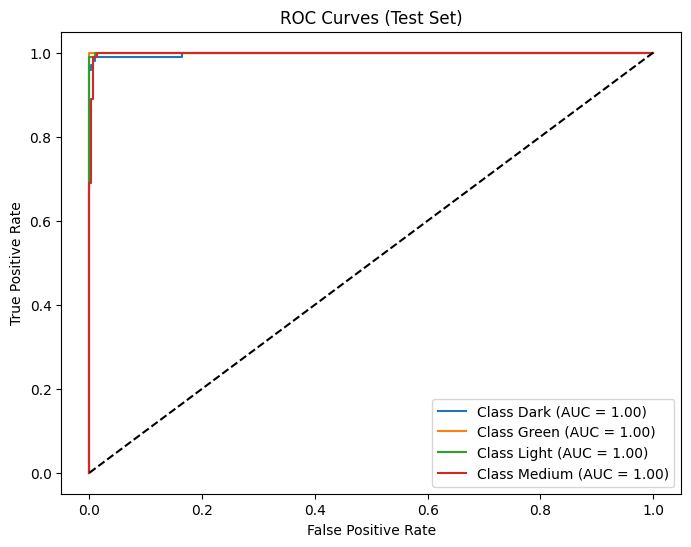

Overall Test AUC: 0.99915


In [11]:
# Predictions
y_test_pred = xgb_clf.predict(X_test_scaled)
y_test_proba = xgb_clf.predict_proba(X_test_scaled)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision (macro):", precision_score(y_test, y_test_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_test_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred, target_names=list(test_gen.class_indices.keys())))

# ROC Curves
classes_present = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes_present)

if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {list(test_gen.class_indices.keys())[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend(); plt.show()

    print("Overall Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")
